In [1]:
import torch
from model import GPTModel

from loguru import logger

GPT_CONFIG_124M = {
    "vocab_size": 50257,   # Vocabulary size
    "context_length": 256, # Shortened context length (orig: 1024)
    "emb_dim": 768,        # Embedding dimension
    "n_heads": 12,         # Number of attention heads
    "n_layers": 12,        # Number of layers
    "drop_rate": 0.1,      # Dropout rate
    "qkv_bias": False      # Query-key-value bias
}

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval()

logger.info("model loaded")

2024-11-22 15:56:22.724 | INFO     | __main__:<module>:20 - model loaded


In [2]:
sum(p.numel() for p in model.parameters())

162419712

In [3]:
import os
import urllib.request

file_path = "the-verdict.txt"
url = "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch02/01_main-chapter-code/the-verdict.txt"

if not os.path.exists(file_path):
    with urllib.request.urlopen(url) as response:
        text_data = response.read().decode('utf-8')
    with open(file_path, "w", encoding="utf-8") as file:
        file.write(text_data)
else:
    with open(file_path, "r", encoding="utf-8") as file:
        text_data = file.read()

logger.info("data downloaded")

2024-11-22 15:56:22.750 | INFO     | __main__:<module>:16 - data downloaded


In [4]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # add batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # remove batch dimension
    return tokenizer.decode(flat.tolist())

total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))

print("Characters:", total_characters)
print("Tokens:", total_tokens)

Characters: 20479
Tokens: 5145


In [5]:
# Train/validation ratio

from dataset import create_dataloader_v1

train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]


torch.manual_seed(123)

train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

In [6]:
train_tokens = 0
for input_batch, target_batch in train_loader:
    train_tokens += input_batch.numel()

val_tokens = 0
for input_batch, target_batch in val_loader:
    val_tokens += input_batch.numel()

print("Training tokens:", train_tokens)
print("Validation tokens:", val_tokens)
print("All tokens:", train_tokens + val_tokens)

Training tokens: 4608
Validation tokens: 512
All tokens: 5120


In [7]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss


def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

In [8]:
from generate import generate_text_simple

def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    # Initialize lists to track losses and tokens seen
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # Calculate loss gradients
            optimizer.step() # Update model weights using loss gradients
            tokens_seen += input_batch.numel()
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Print a sample text after each epoch
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen


def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss


def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))  # Compact print format
    model.train()

In [9]:
torch.manual_seed(123)

device = torch.device('cuda')

model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="Every effort moves you", tokenizer=tokenizer
)

Ep 1 (Step 000000): Train loss 9.817, Val loss 9.928
Ep 1 (Step 000005): Train loss 8.068, Val loss 8.339
Every effort moves you,.                                                
Ep 2 (Step 000010): Train loss 6.625, Val loss 7.052
Ep 2 (Step 000015): Train loss 6.046, Val loss 6.601
Every effort moves you, and,, and,, and,,,, and,.                                   
Ep 3 (Step 000020): Train loss 5.549, Val loss 6.500
Ep 3 (Step 000025): Train loss 5.436, Val loss 6.382
Every effort moves you, and to the of the of the of the, and I had. Gis, and, and, and, and, and, and I had, and, and, and, and, and, and, and, and, and,
Ep 4 (Step 000030): Train loss 4.963, Val loss 6.280
Ep 4 (Step 000035): Train loss 4.702, Val loss 6.293
Every effort moves you, I had.    "I had been.               "I"I the picture"I had the the honour of the picture and I had been.  
Ep 5 (Step 000040): Train loss 4.078, Val loss 6.158
Every effort moves you know the                                                

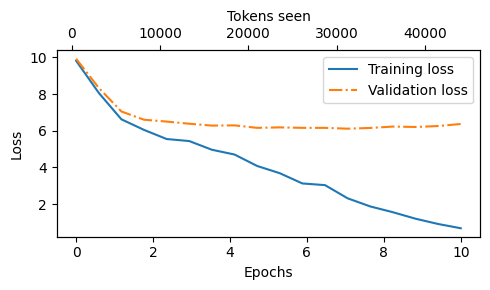

In [10]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # only show integer labels on x-axis

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig("loss-plot.pdf")
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

In [11]:
model.to("cpu")
model.eval()

tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=25,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you?"

"Yes--quite insensible to the irony. She wanted him vindicated--and by me!"




In [12]:
model.trf_blocks[0].att.W_query, model.trf_blocks[0].att.W_key, model.trf_blocks[0].att.W_value

(Linear(in_features=768, out_features=768, bias=False),
 Linear(in_features=768, out_features=768, bias=False),
 Linear(in_features=768, out_features=768, bias=False))

In [13]:
feats = {}

def hook_func(m , inp ,op):
   feats[m] = op.detach()

model.trf_blocks[0].att.W_query.register_forward_hook(hook_func)
model.trf_blocks[0].att.W_key.register_forward_hook(hook_func)
model.trf_blocks[0].att.W_value.register_forward_hook(hook_func)

In [14]:
output = model(token_ids)

In [15]:
feats.keys()

dict_keys([Linear(in_features=768, out_features=768, bias=False), Linear(in_features=768, out_features=768, bias=False), Linear(in_features=768, out_features=768, bias=False)])

In [ ]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# data = feats['feat'].squeeze(0)

# plt.figure(figsize=(12, 12))
# sns.heatmap(data.numpy(), cmap="viridis", cbar=True)

# plt.title("Heatmap of Tensor")
# plt.xlabel("Feature Dimension")
# plt.ylabel("Sequence Length")
# plt.show()

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_heatmap(data):
    min_val = data.min()
    max_val = data.max()
    normalized_data = (data - min_val) / (max_val - min_val)

    plt.figure(figsize=(15, 20))

    # Iterate over each sequence position
    for i in range(normalized_data.shape[0]):  # 29 sequences
        plt.subplot(normalized_data.shape[0], 1, i + 1)  # Create a subplot for each row
        sns.heatmap(
            normalized_data[i].unsqueeze(0).numpy(),
            cmap="magma",
            cbar=(i == normalized_data.shape[0] - 1), 
            xticklabels=False,
            yticklabels=False,
            cbar_kws={"orientation": "horizontal", "pad": 0.2},
        )
        plt.ylabel(f"{i+1}", rotation=0, fontsize=8, labelpad=15)

    plt.xlabel("Feature Dimension", fontsize=12, labelpad=10)
    plt.tight_layout()
    plt.show()


def plot_hist(data):
    min_val = data.min()
    max_val = data.max()
    normalized_data = (data - min_val) / (max_val - min_val)

    rows = 32 
    cols = 24  # (32 x 24 = 768)
    fig, axes = plt.subplots(rows, cols, figsize=(20, 40))

    axes = axes.flatten()

    # Create histograms for each feature dimension
    for i in range(normalized_data.shape[1]):  # Iterate over 768 feature dimensions
        axes[i].hist(normalized_data[:, i].numpy(), bins=10, color='blue', alpha=0.7)
        axes[i].set_title(f"Feature {i+1}", fontsize=6)
        axes[i].set_xticks([]) 
        axes[i].set_yticks([])  

    for j in range(normalized_data.shape[1], len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()

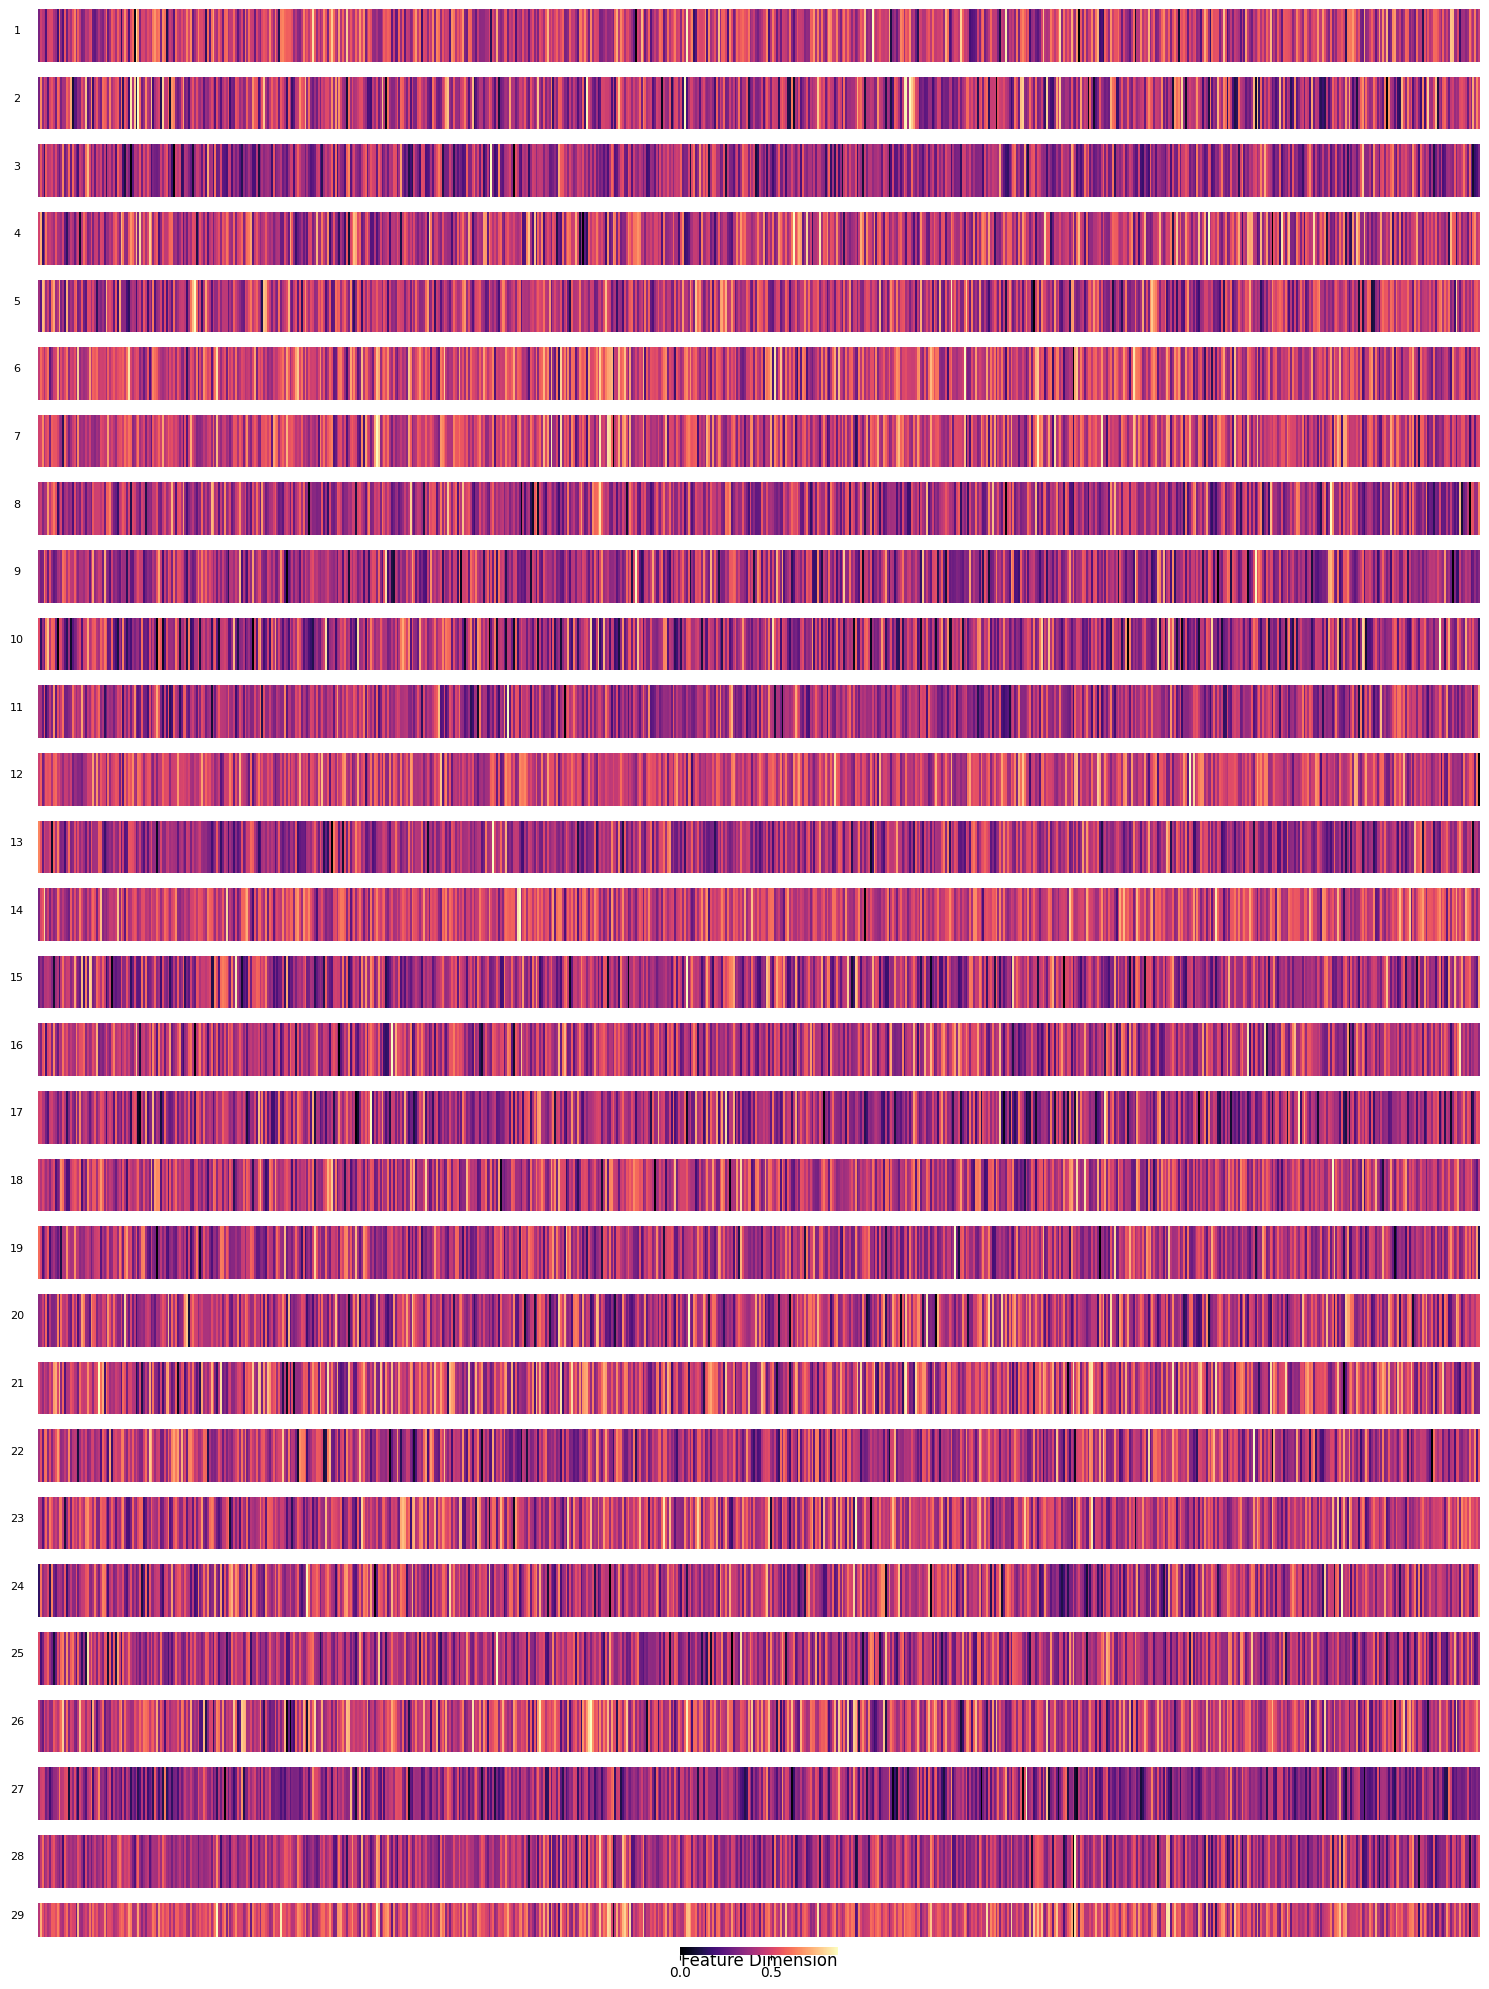

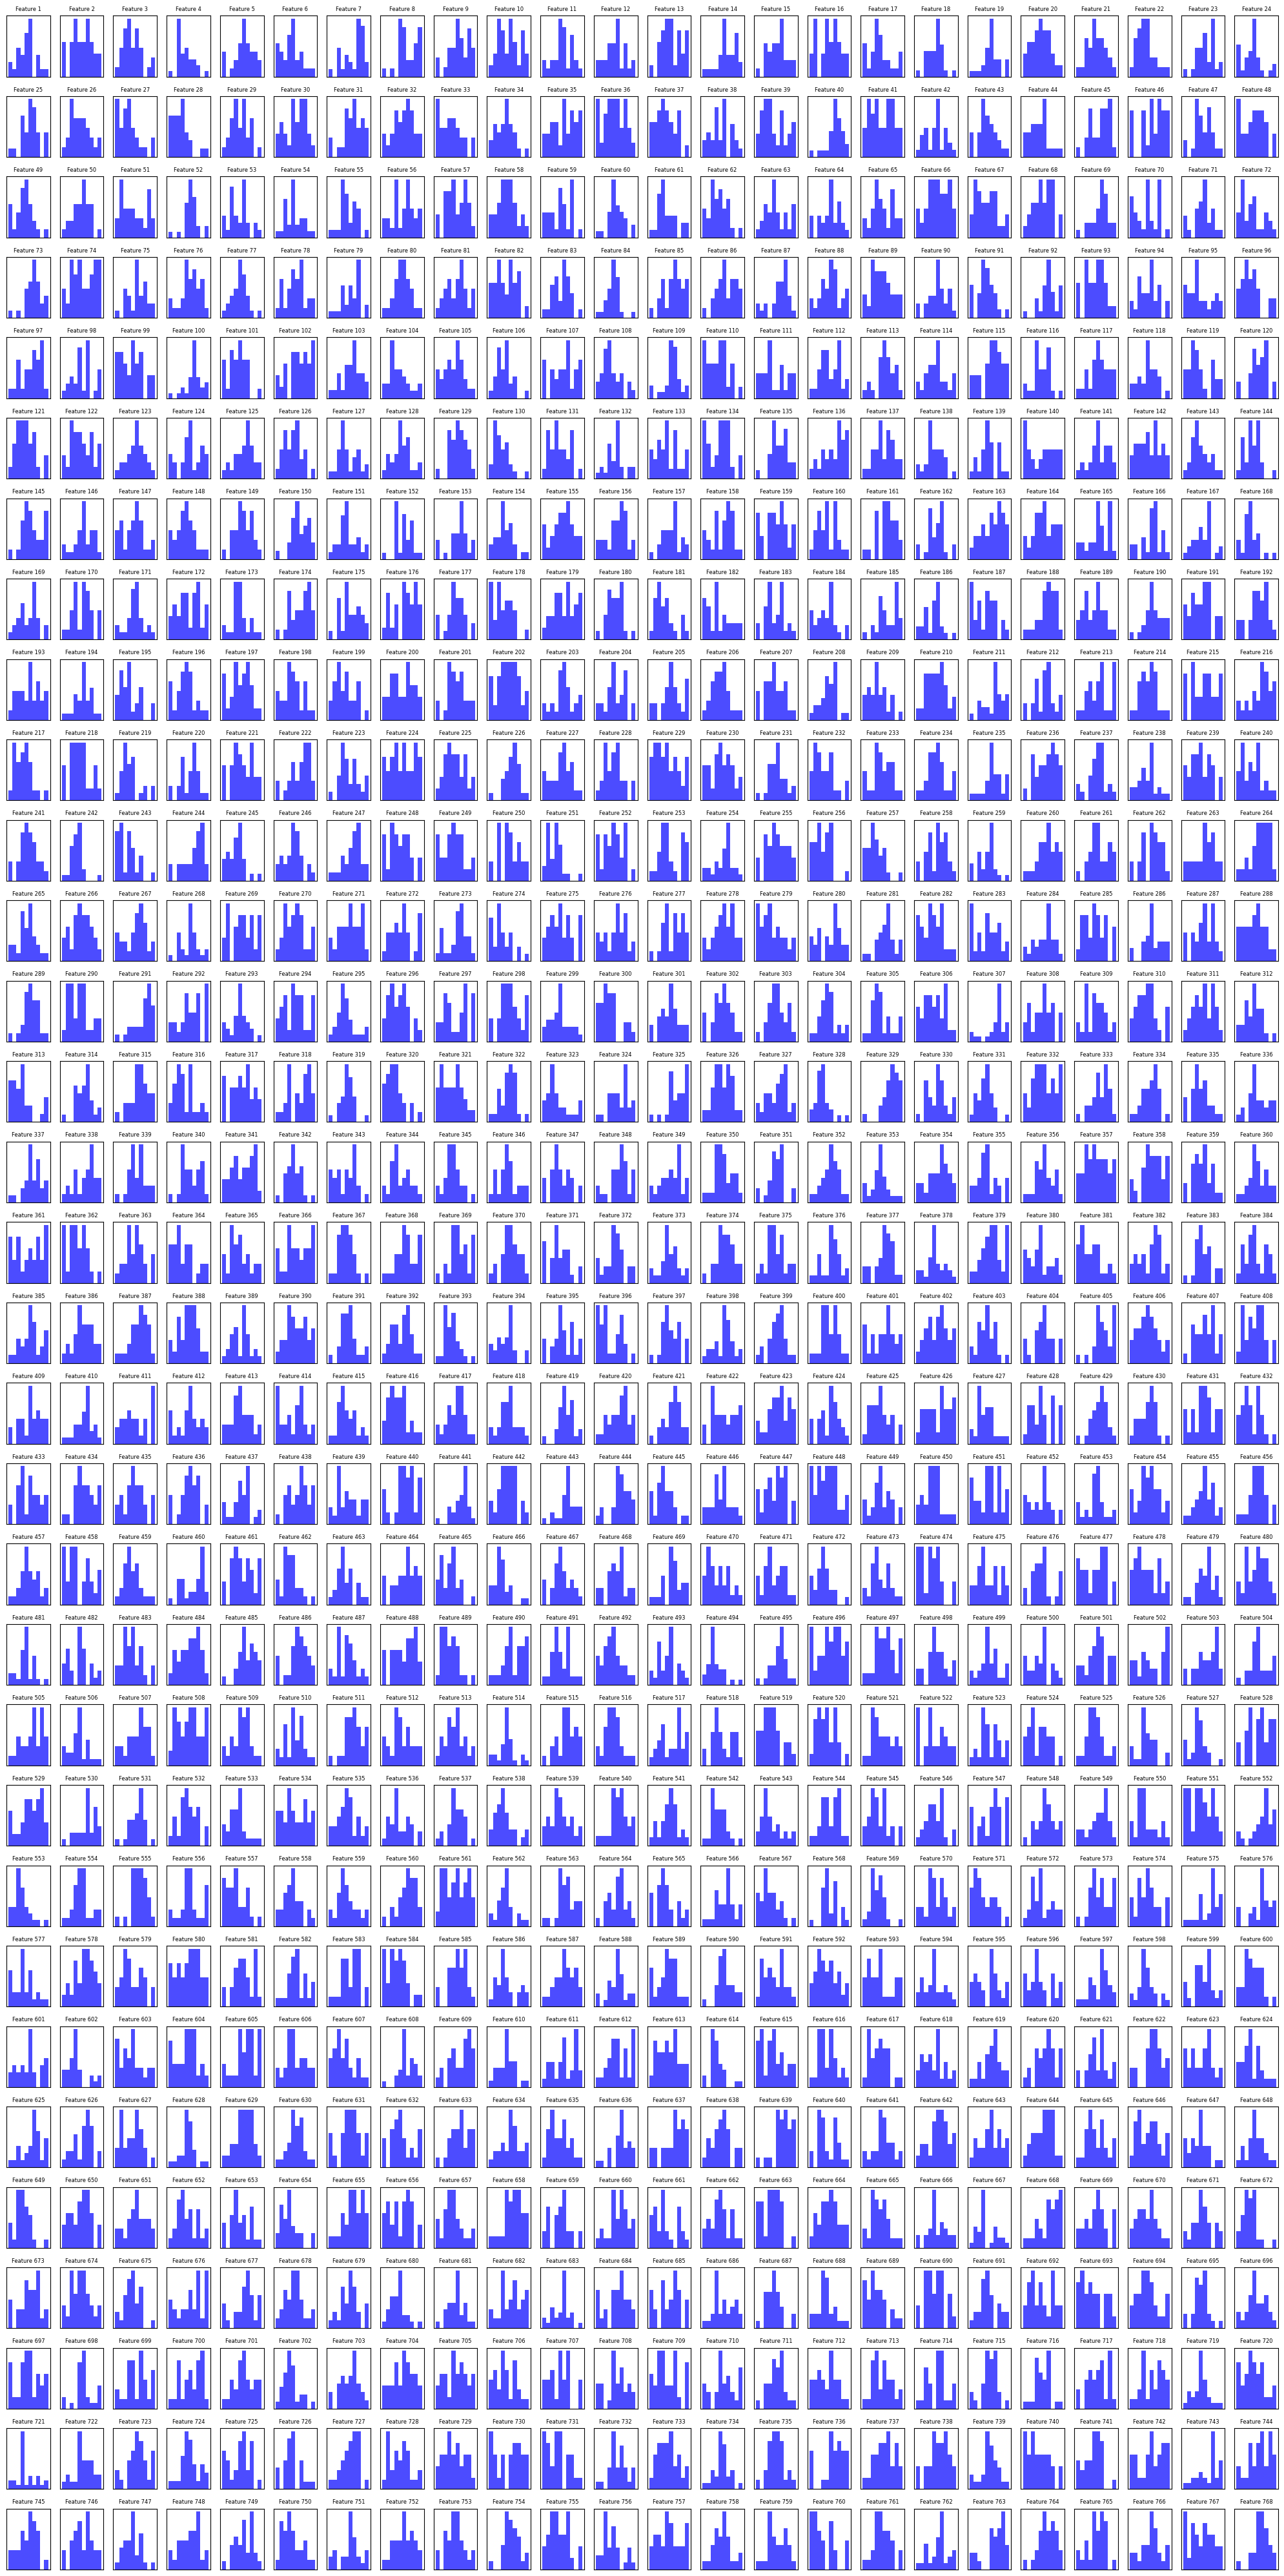

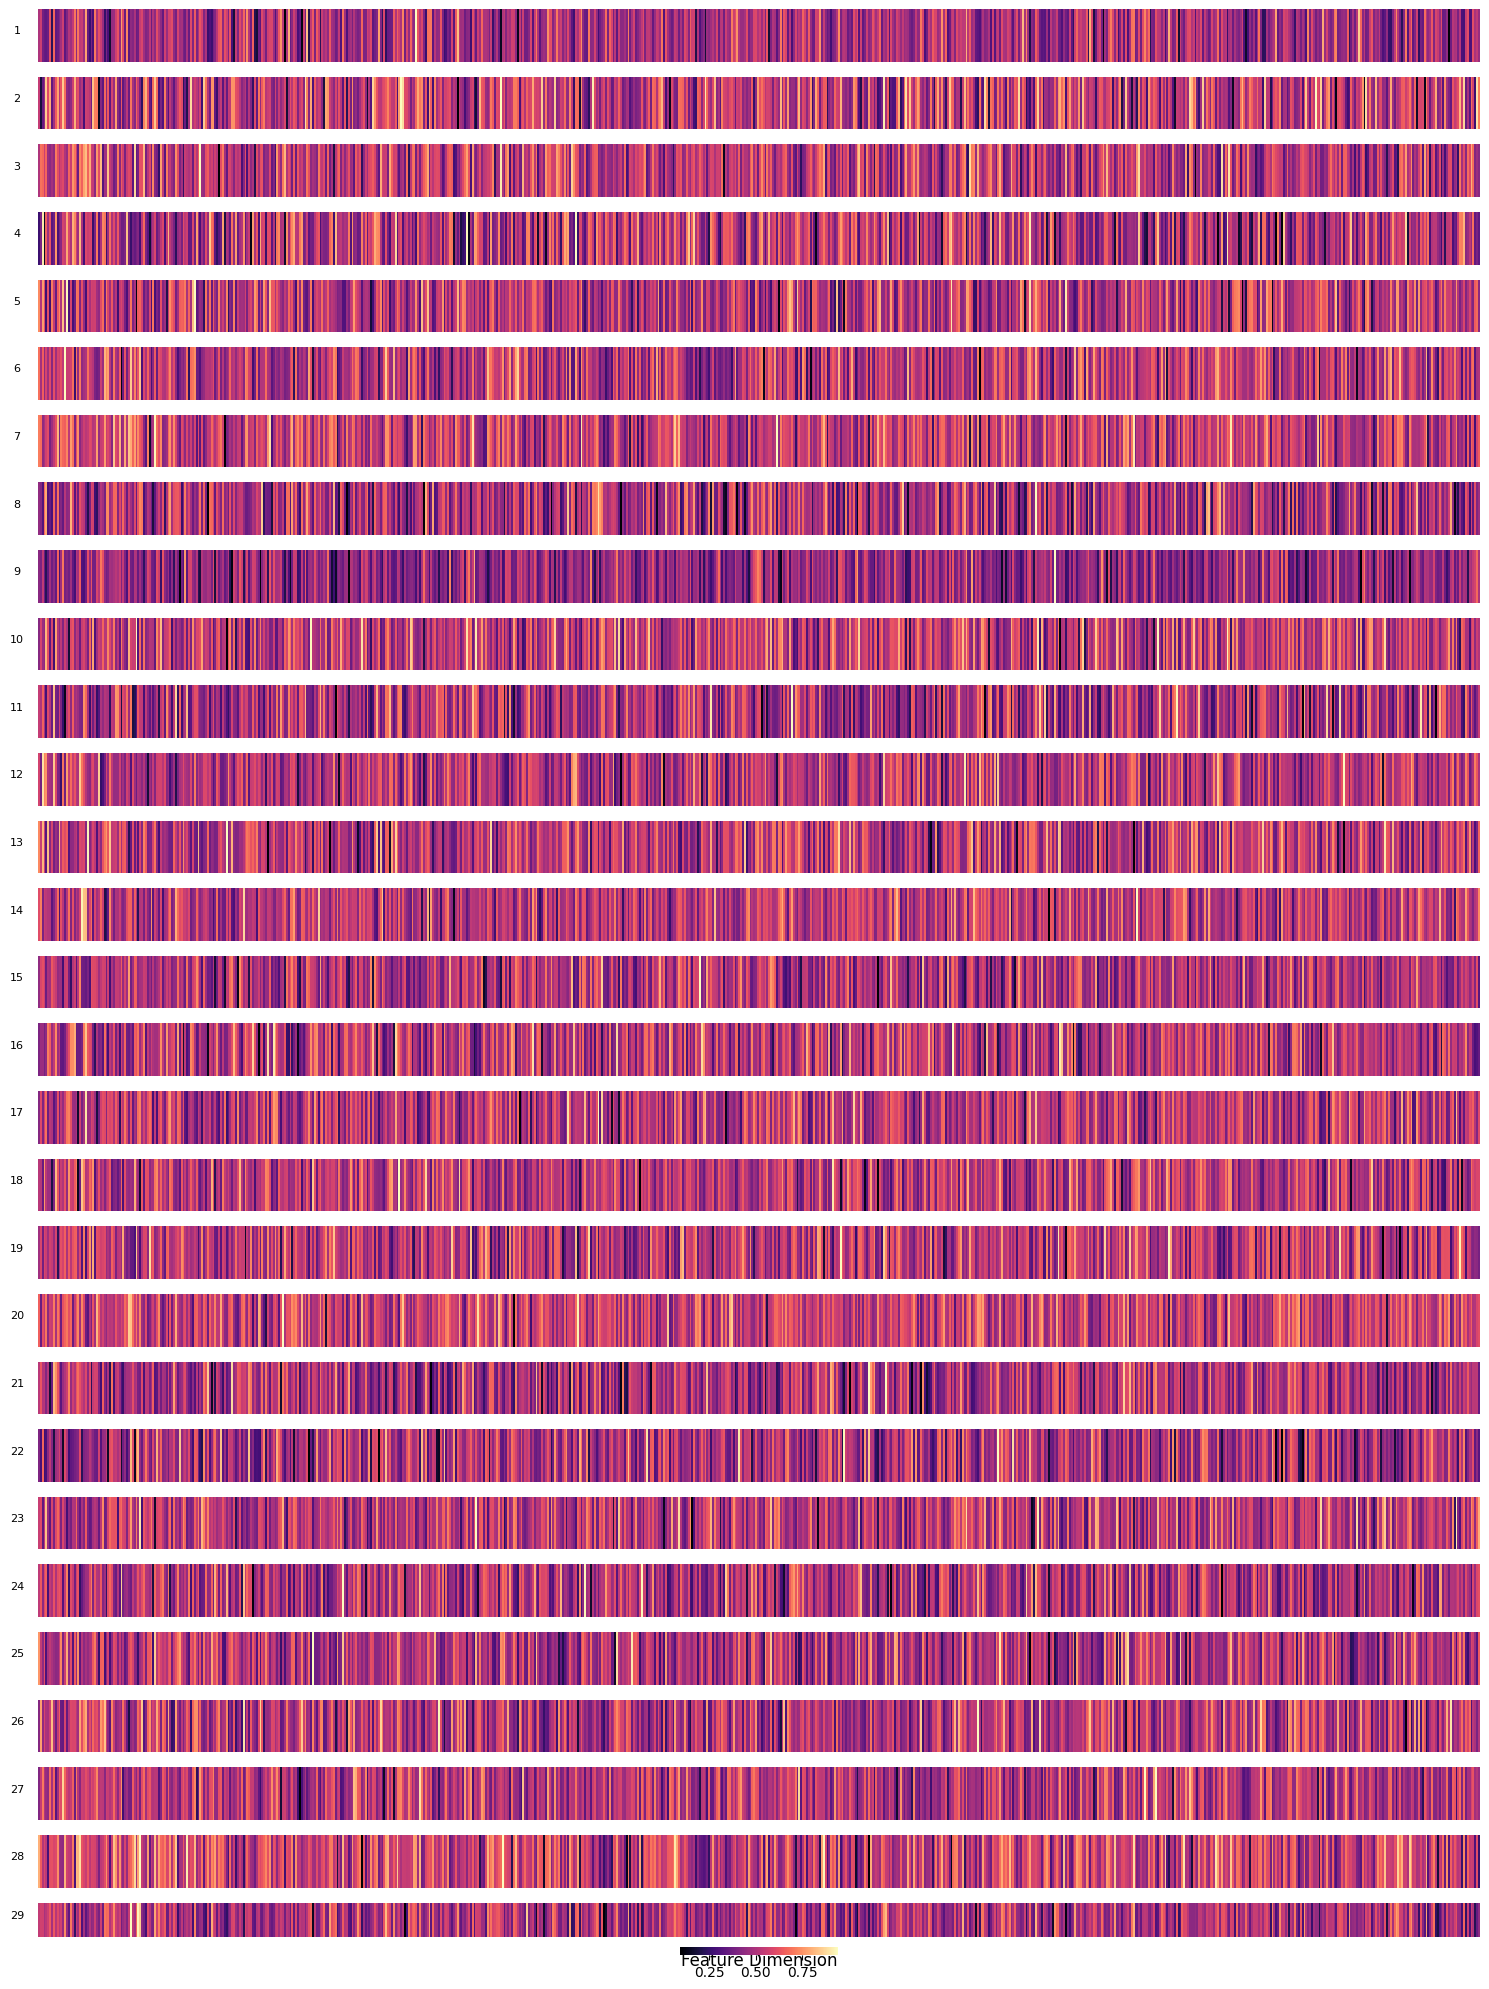

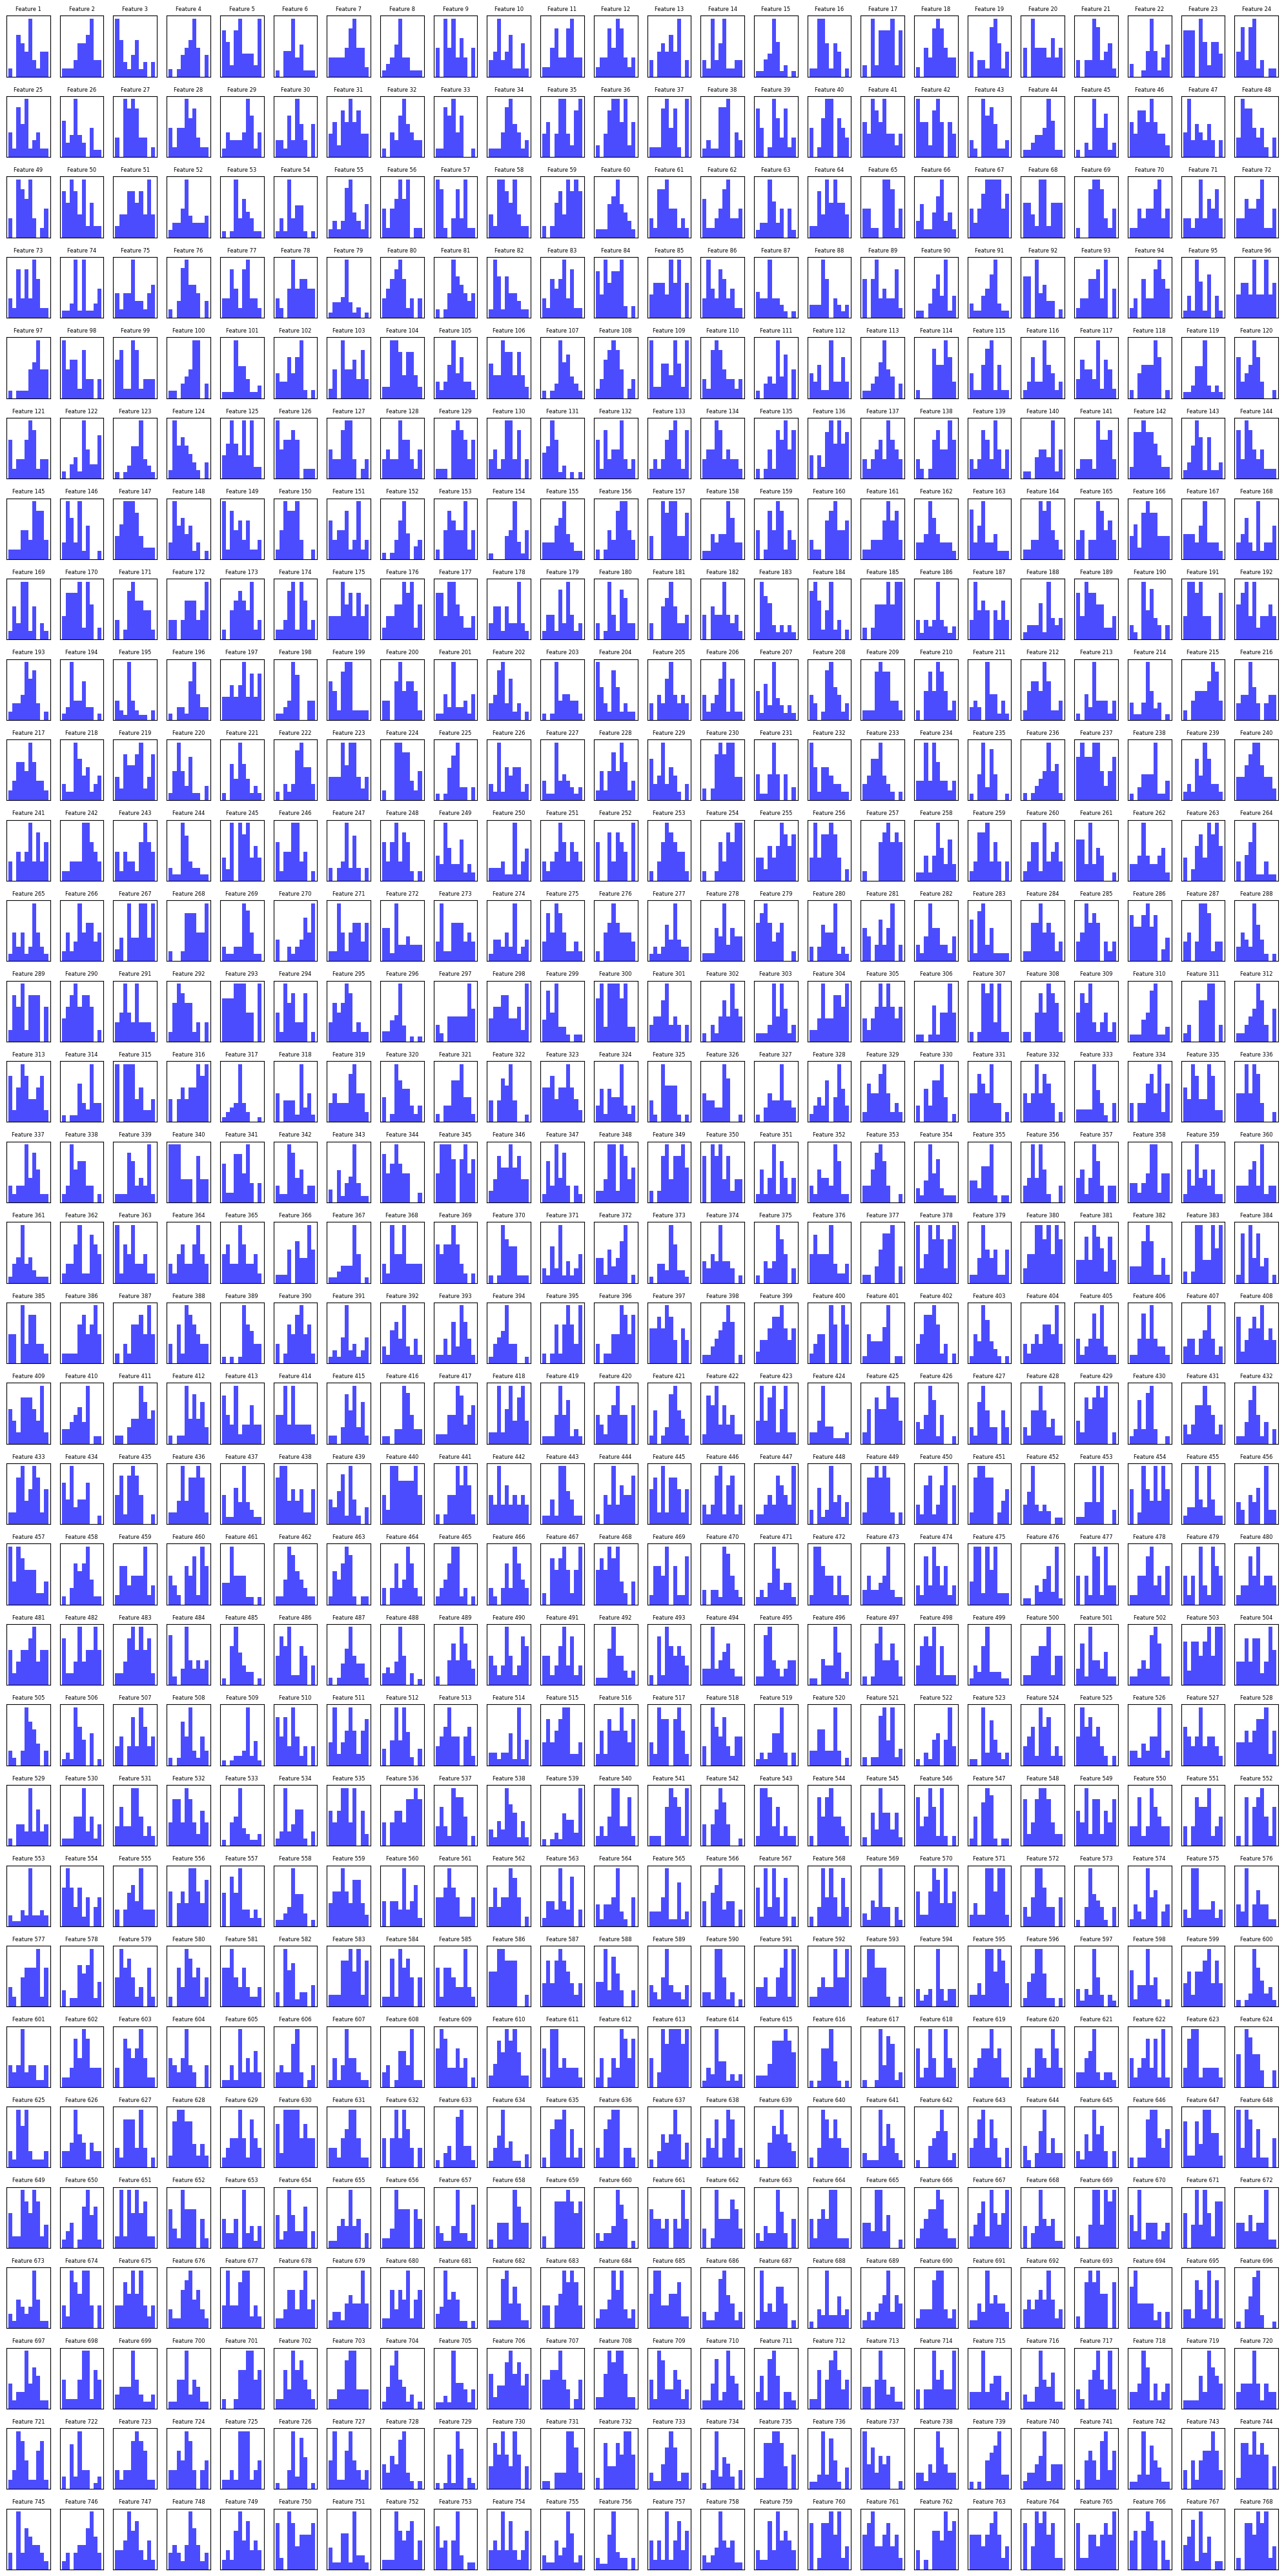

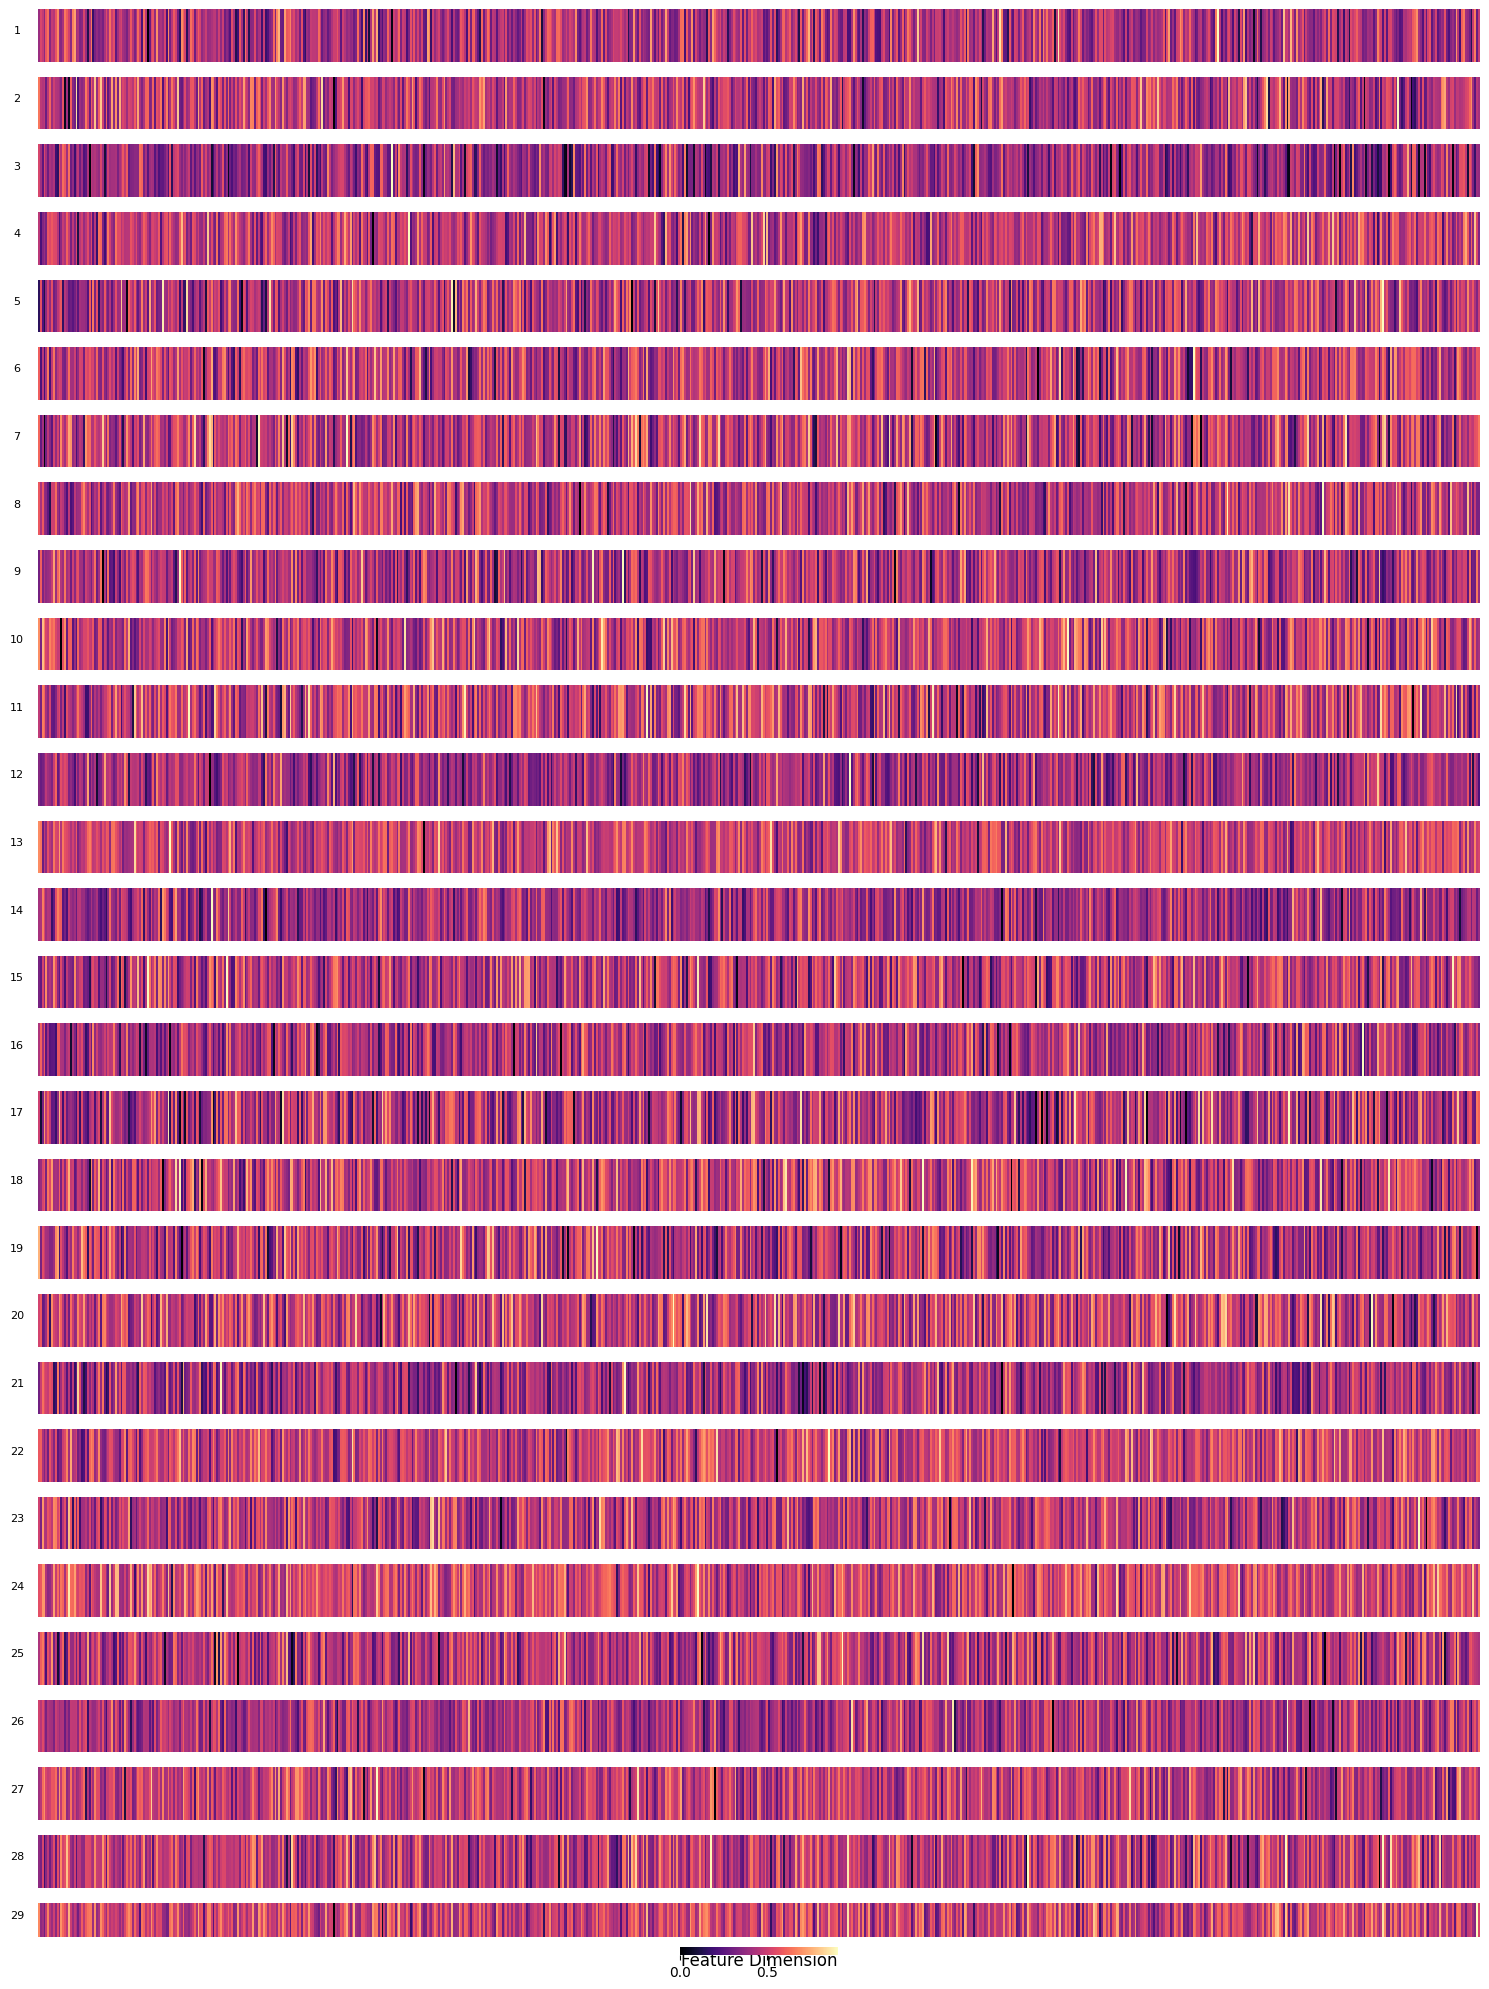

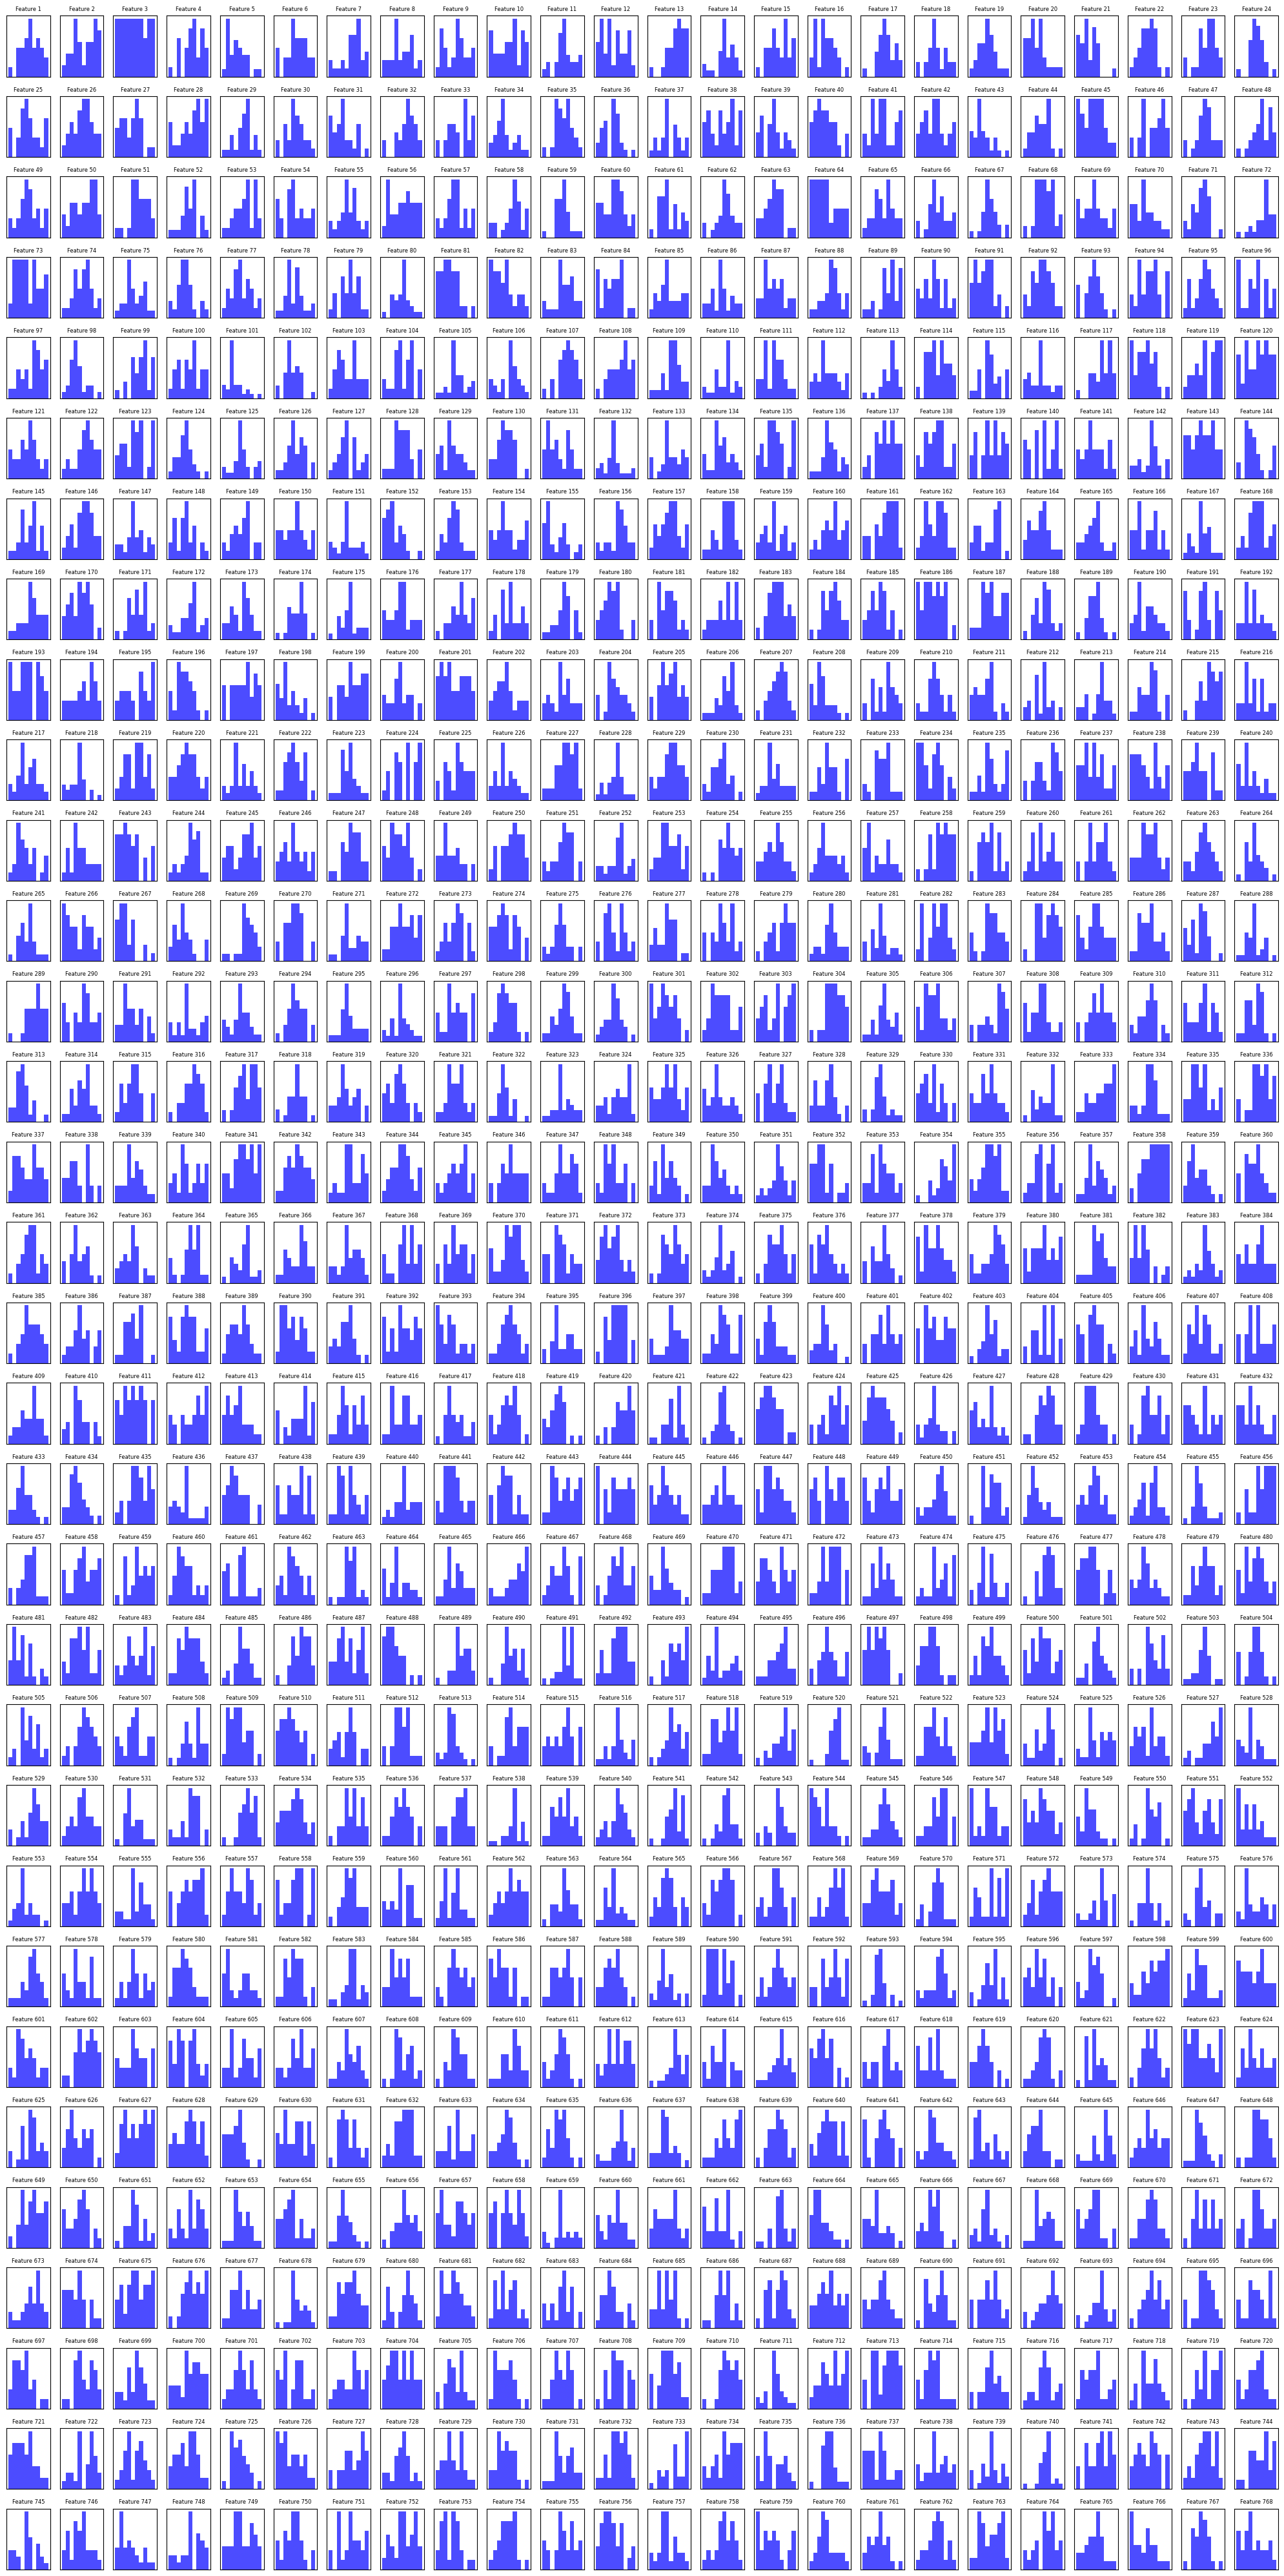

In [23]:
for _k, _v in feats.items():
    plot_heatmap(_v.squeeze(0))
    plot_hist(_v.squeeze(0))